In [11]:
from transformers import AutoImageProcessor
import torchvision.transforms as transforms
import numpy as np
import torch
from trak import TRAKer

from src.train import train_model
from src.early_stopping import EarlyStopping
from src.dataset import get_dataset_split, get_dl_targets, get_chosen_classes
from src.model import get_model, compute_val_dataset_predictions, recall_for_class
from src.trak_utils import ResNetOutput, featurize_traker, get_traker_scores
from src.plots import plot_single_image, plot_extreme_two_trak_examples_for_image
from src.class_metrics import compute_class_weights, compute_class_alignment_scores, compute_class_weights_original_formula


torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
args = {
    'lr': 1e-4, 
    'batch_size': 64,
    'batch_size_reduced': 32,
    'num_epochs': 20,
    'epochs_per_checkpoint': 1,
    'dataset_path': "data/food-101/food-101/images",
    'resnet_version': "microsoft/resnet-18",
    'train_split_rate': 0.8,
    'test_split_rate': 0.2
}

In [13]:
processor = AutoImageProcessor.from_pretrained(args['resnet_version'])

def preprocess_image(image):
    image = transforms.functional.pil_to_tensor(image)
    processed_image = processor.preprocess(image)["pixel_values"][0]
    return torch.from_numpy(processed_image)

# classes:
# bruschetta, garlic bread, grilled salmon, omelette, pancakes,
# pizza, porkchop, spaghetti bolognese, spaghetti carbonara, steak

num_classes = 10
chosen_indices = [10, 46, 50, 67, 72, 76, 77, 90, 91, 93]

assert num_classes == len(chosen_indices)

chosen_classes = get_chosen_classes(args['dataset_path'], chosen_indices)

print("Chosen classes: " + str(chosen_classes))

train_dataset, test_dataset = get_dataset_split(args['dataset_path'], chosen_indices, args['train_split_rate'], args['test_split_rate'], preprocess_image)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

model = get_model(args['resnet_version'], num_classes)

Chosen classes: ['bruschetta', 'garlic_bread', 'grilled_salmon', 'omelette', 'pancakes', 'pizza', 'pork_chop', 'spaghetti_bolognese', 'spaghetti_carbonara', 'steak']


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
model_finetuned_path = "model_finetuned_baseline.pth"

train_model(model, train_dl, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping, epochs_per_checkpoint=args['epochs_per_checkpoint'], model_save_path=model_finetuned_path)

torch.save(model.state_dict(), model_finetuned_path)

100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


[Epoch 1] Loss: 0.921, Train Acc: 0.697,Valid loss: 0.565 Valid Acc: 0.803


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]


[Epoch 2] Loss: 0.272, Train Acc: 0.925,Valid loss: 0.521 Valid Acc: 0.829


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


[Epoch 3] Loss: 0.058, Train Acc: 0.994,Valid loss: 0.563 Valid Acc: 0.823


 49%|████▉     | 61/125 [01:25<01:30,  1.41s/it]


KeyboardInterrupt: 

In [4]:
model_finetuned_path = "model_finetuned_baseline.pth"
checkpoint = torch.load(model_finetuned_path,  map_location=device)
model.load_state_dict(checkpoint)
model = model.to(device)

In [5]:
train_dl_no_shuffle = torch.utils.data.DataLoader(train_dataset, batch_size=args['batch_size_reduced'], shuffle=False)
test_dl_no_shuffle = torch.utils.data.DataLoader(test_dataset, batch_size=args['batch_size_reduced'], shuffle=False)

In [10]:
traker = TRAKer(model=model,
                task=ResNetOutput(),
                train_set_size=len(train_dl_no_shuffle.dataset))

ERROR:TRAK:Could not use CudaProjector.
Reason: No module named 'fast_jl'
ERROR:TRAK:Defaulting to BasicProjector.
INFO:STORE:No existing model IDs in C:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\automating science\trak-for-automating-science\trak_results.
INFO:STORE:No existing TRAK scores in C:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\automating science\trak-for-automating-science\trak_results.


In [12]:
model_id = 0
test_scores_path = "test_scores.npy"
traker.load_checkpoint(checkpoint, model_id=0)

exp_name = "test_val"

featurize_traker(traker, train_dl_no_shuffle)

test_scores = get_traker_scores(traker, exp_name, checkpoint, model_id, test_dl) 

np.save(test_scores_path, test_scores)

  0%|          | 0/250 [00:00<?, ?it/s]c:\Users\kamil\anaconda3\envs\ml_gnn\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  1%|          | 3/250 [00:25<35:16,  8.57s/it]


KeyboardInterrupt: 

In [6]:
test_scores_path = "test_scores.npy"
test_scores = np.load(test_scores_path)

In [7]:
targets = get_dl_targets(test_dl_no_shuffle)

preds = compute_val_dataset_predictions(model, test_dl_no_shuffle)

class_weights = compute_class_weights(preds, targets, num_classes)
class_weights

100%|██████████| 63/63 [00:23<00:00,  2.69it/s]


array([1.4993402 , 1.80096332, 1.62367519, 1.97532214, 1.4679156 ,
       1.64563529, 2.81865445, 1.1564214 , 1.14151641, 1.90696474])

In [8]:
group_alignment_scores = compute_class_alignment_scores(test_scores, targets, class_weights, num_classes)
(group_alignment_scores < 0).sum()

100%|██████████| 8000/8000 [00:01<00:00, 6023.26it/s]


1049

In [11]:
# looking to remove only a small fraction of hopefully impactful examples
sorted_group_alignment_scores = np.sort(group_alignment_scores)
top_k_to_remove = 200
example_indices_to_keep = np.nonzero(~(group_alignment_scores < sorted_group_alignment_scores[top_k_to_remove]))[0]
len(example_indices_to_keep)

7800

In [14]:
train_data_after_trak = torch.utils.data.Subset(train_dataset, example_indices_to_keep)
train_dl_after_trak = torch.utils.data.DataLoader(train_data_after_trak, batch_size=args['batch_size'], shuffle=True)

model_after_trak = get_model(args['resnet_version'], num_classes)

In [15]:
optimizer = torch.optim.Adam(model_after_trak.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
model_after_trak_path = "model_after_trak.pth"

# TODO make sure that we start from the same weights as the baseline model
train_model(model_after_trak, train_dl_after_trak, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

torch.save(model_after_trak.state_dict(), model_after_trak_path)

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


[Epoch 1] Loss: 0.885, Train Acc: 0.709,Valid loss: 0.582 Valid Acc: 0.804


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


[Epoch 2] Loss: 0.264, Train Acc: 0.927,Valid loss: 0.526 Valid Acc: 0.823


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


[Epoch 3] Loss: 0.074, Train Acc: 0.989,Valid loss: 0.502 Valid Acc: 0.841


  7%|▋         | 8/122 [00:07<01:45,  1.08it/s]


KeyboardInterrupt: 

In [14]:
checkpoint = torch.load(model_after_trak_path, map_location=device)
model_after_trak.load_state_dict(checkpoint)
model_after_trak = model_after_trak.to(device)

## Improved predictions on some examples

In [15]:
preds_after_trak = compute_val_dataset_predictions(model_after_trak, test_dl_no_shuffle)
class_weights_after_trak = compute_class_weights(preds_after_trak, targets, num_classes)

100%|██████████| 63/63 [00:20<00:00,  3.04it/s]


In [16]:
# worst class performance has improved and all the other classes' performance is similar
# suggesting that the change in the formula was correct - the results are what they should be

class_weights_after_trak, class_weights, class_weights_after_trak - class_weights

(array([1.78327515, 1.89360222, 2.29612765, 1.92669078, 1.69920765,
        1.36719906, 2.22070079, 1.22156309, 1.17656689, 2.25599606]),
 array([1.49581848, 1.78777763, 1.67554634, 2.03231165, 1.43815503,
        1.65485064, 3.4280398 , 1.1774615 , 1.15551179, 1.76826248]),
 array([ 0.28745667,  0.10582459,  0.62058131, -0.10562087,  0.26105262,
        -0.28765159, -1.20733901,  0.04410159,  0.02105509,  0.48773358]))

In [17]:
# the worst class was class number 1 - "garlic bread"
# now we will examine both models' performance on this class

f"{recall_for_class(model, test_dl_no_shuffle, 1):.3f}", f"{recall_for_class(model_after_trak, test_dl_no_shuffle, 1):.3f}"

 16%|█▌        | 10/63 [00:03<00:17,  3.08it/s]c:\Users\kamil\anaconda3\envs\ml_gnn\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


('0.838', '0.847')

## Surprising / insightful examples

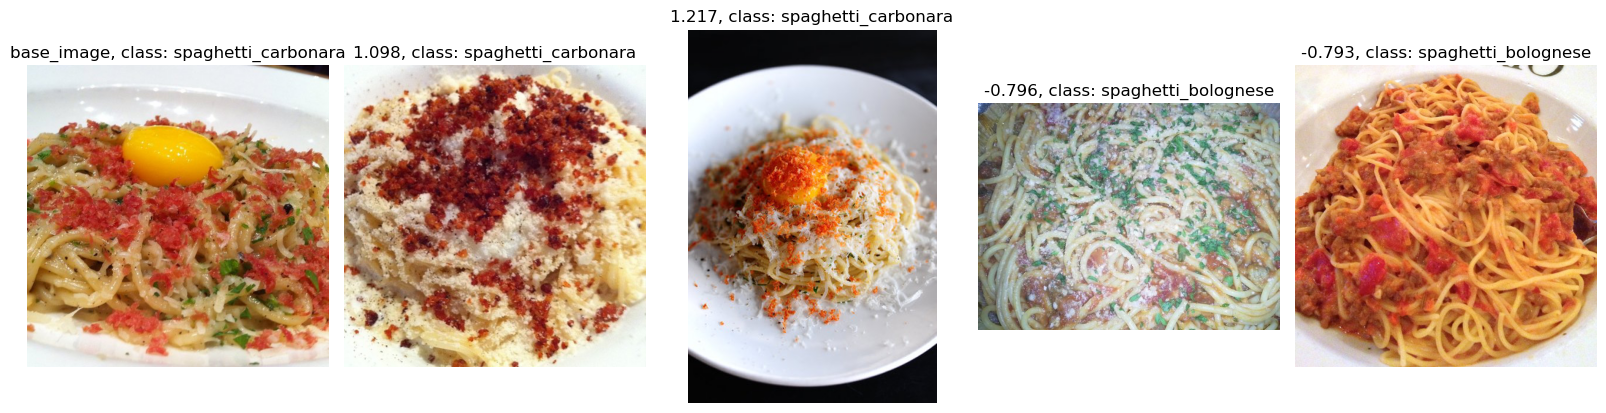

In [18]:
train_dataset_no_transform, test_dataset_no_transform = get_dataset_split(
    args['dataset_path'],
    chosen_indices,
    args['train_split_rate'],
    args['test_split_rate'],
    transforms.ToTensor())

image_id = 6

plot_extreme_two_trak_examples_for_image(test_scores, train_dataset_no_transform, test_dataset_no_transform, image_id, chosen_classes)

In [20]:
# the hope is that TRAK could help us in finding such images so that we could remove them
# let's examine a mislabeled image

mislabeled_image_id = 4258

# the position of mislabeled image score amongst all scores
len(group_alignment_scores[group_alignment_scores >= group_alignment_scores[mislabeled_image_id]])

2387

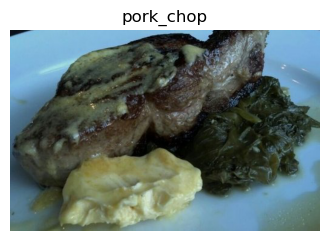

In [21]:
# let's examine the image (and its class), where the alignment score is the highest

top_alignment_image_id = np.argmax(group_alignment_scores)
top_alignment_image = train_dataset_no_transform[top_alignment_image_id][0]
top_alignment_image_class = train_dataset_no_transform[top_alignment_image_id][1]

plot_single_image(top_alignment_image, chosen_classes[top_alignment_image_class])

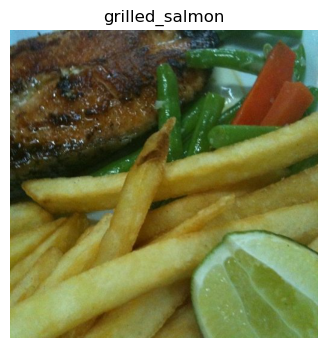

In [22]:
# let's examine the image with lowest score

bottom_alignment_image_id = np.argmin(group_alignment_scores)
bottom_alignment_image = train_dataset_no_transform[bottom_alignment_image_id][0]
bottom_alignment_image_class = train_dataset_no_transform[bottom_alignment_image_id][1]

plot_single_image(bottom_alignment_image, chosen_classes[bottom_alignment_image_class])

## Original class weights formula

In [23]:
# just to be sure, let's repeat the experiment with the original formula for computing class weights
class_weights_orig = compute_class_weights_original_formula(preds, targets, num_classes)
group_alignment_scores_orig = compute_class_alignment_scores(test_scores, targets, class_weights_orig, num_classes)
sorted_group_alignment_scores_orig = np.sort(group_alignment_scores_orig)
example_indices_to_keep_orig = np.nonzero(~(group_alignment_scores_orig < sorted_group_alignment_scores_orig[top_k_to_remove]))[0]

100%|██████████| 8000/8000 [00:01<00:00, 6406.15it/s]


In [25]:
mislabeled_image_id = 4258

# the position of mislabeled image score amongst all scores
len(group_alignment_scores_orig[group_alignment_scores_orig >= group_alignment_scores_orig[mislabeled_image_id]]), group_alignment_scores_orig[mislabeled_image_id]

(496, 0.046242162954481414)

## Opposite experiment - removing most positively impactful examples

In [27]:
# using changed formula for computing class weights
top_k_to_remove = 200
example_indices_to_keep_2 = np.nonzero(~(group_alignment_scores >= sorted_group_alignment_scores[len(group_alignment_scores) - top_k_to_remove]))[0]

train_data_after_trak_2 = torch.utils.data.Subset(train_dataset, example_indices_to_keep_2)
train_dl_after_trak_2 = torch.utils.data.DataLoader(train_data_after_trak_2, batch_size=args['batch_size'], shuffle=True)

model_after_trak_2 = get_model(args['resnet_version'], num_classes)

In [28]:
optimizer = torch.optim.Adam(model_after_trak_2.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing most positively impactful examples selected by TRAK - valid loss: 0.502, valid acc: 0.834
train_model(model_after_trak_2, train_dl_after_trak_2, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


[Epoch 1] Loss: 0.875, Train Acc: 0.714,Valid loss: 0.578 Valid Acc: 0.808


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


[Epoch 2] Loss: 0.271, Train Acc: 0.924,Valid loss: 0.551 Valid Acc: 0.814


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


[Epoch 3] Loss: 0.070, Train Acc: 0.991,Valid loss: 0.529 Valid Acc: 0.832


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


[Epoch 4] Loss: 0.022, Train Acc: 0.999,Valid loss: 0.546 Valid Acc: 0.837


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.540 Valid Acc: 0.843


100%|██████████| 32/32 [00:22<00:00,  1.43it/s]

[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.555 Valid Acc: 0.839
Early stopping at epoch 6


In [100]:
torch.save(model_after_trak_2.state_dict(), "model_after_trak_top_scores_removed.pth")

## Original heuristic - removing all examples with negative alignment score

In [32]:
example_indices_to_keep = np.nonzero(~(group_alignment_scores < 0))[0]
len(example_indices_to_keep)

5114

In [33]:
train_data_after_trak = torch.utils.data.Subset(train_dataset, example_indices_to_keep)
train_dl_after_trak = torch.utils.data.DataLoader(train_data_after_trak, batch_size=args['batch_size'], shuffle=True)

model_after_trak = get_model(args['resnet_version'], num_classes)

In [104]:
optimizer = torch.optim.Adam(model_after_trak.parameters(), lr=args['lr'])
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing all examples with negative alignment score - val loss: 0.542, val acc: 0.829
train_model(model_after_trak, train_dl_after_trak, test_dl, args['num_epochs'], optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:44<00:00,  1.39s/it]


[Epoch 1] Loss: 0.987, Train Acc: 0.680,Valid loss: 0.659 Valid Acc: 0.780


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


[Epoch 2] Loss: 0.278, Train Acc: 0.924,Valid loss: 0.595 Valid Acc: 0.799


100%|██████████| 32/32 [00:42<00:00,  1.34s/it]


[Epoch 3] Loss: 0.079, Train Acc: 0.991,Valid loss: 0.542 Valid Acc: 0.829


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


[Epoch 4] Loss: 0.028, Train Acc: 0.999,Valid loss: 0.550 Valid Acc: 0.825


100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


[Epoch 5] Loss: 0.014, Train Acc: 1.000,Valid loss: 0.549 Valid Acc: 0.831


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]

[Epoch 6] Loss: 0.009, Train Acc: 1.000,Valid loss: 0.561 Valid Acc: 0.825
Early stopping at epoch 6


## Shortcut learning / simplicity bias

In [ ]:
# nothing we found in this regard - we found the results unintuitive (although worst-class performance improved after removing examples with TRAK)